### Course: CSC671-02 
#### Team Number：05
#### Members:
##### Jung Hyun Song 
##### Jeremy Woodling
##### Zicheng Tan 
---

## Some Important Library

In [1]:
import pandas as pd
import tensorflow as tf
import keras
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense,Bidirectional,BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt



### Read CSV file  
##### Dataset:  https://www.kaggle.com/datasets/shanegerami/ai-vs-human-text

generated
0.0    305797
1.0    181438
Name: count, dtype: int64


<Axes: >

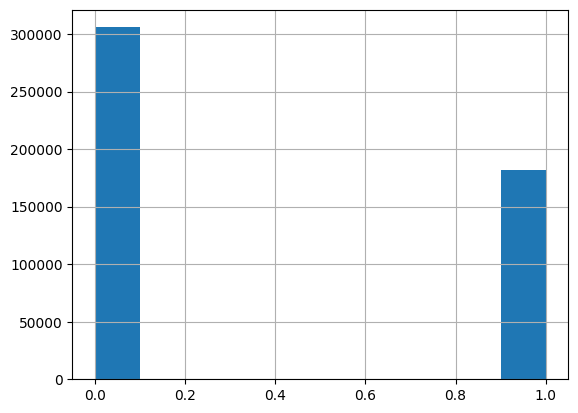

In [2]:
df = pd.read_csv('./AI_Human.csv')
# Print out the first essay for comparison purposes
print(df['generated'].value_counts())
df['generated'].hist()

### some helper function: Phrase the text, padding the sentence into sequence, and etc

In [3]:
## These Function use to phase the text and padding sequences number from text
## Removing the punctuation and stop words could Improve efficiency of the model and enhance algorithm performance
def remove_punctuation_and_stop_words(text):
    cleaned_text = str.maketrans('', '', string.punctuation)
    text = text.translate(cleaned_text)
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    filtered_words = [word for word in word_tokens if word.lower() not in stop_words]  
    filtered_words= ' '.join(filtered_words)
    return filtered_words

## Tranform the text into a sequences number that the model could understand and process=
def pad_sequences_function(text):
    sequences = tokenizer.texts_to_sequences(text)
    output = pad_sequences(sequences, padding='post', maxlen = max_len)
    return output

def format_the_output(results):
    return [1 if output >= 0.5 else 0 for output in results]

def get_the_Accuracy(X,y):
    n= len(X)
    accuracy = (y == X).sum() / n
    return accuracy

def conver_to_tensor(X_train,X_test,y_train,y_test):
    X_train = tf.convert_to_tensor( X_train, dtype=tf.int32)
    X_test = tf.convert_to_tensor( X_test, dtype=tf.int32)
    y_train = tf.convert_to_tensor( y_train, dtype=tf.int32)
    y_test = tf.convert_to_tensor( y_test, dtype=tf.int32)
    return X_train,X_test,y_train,y_test



### Text Preprocessing

In [4]:
#if error shows up because of the nltk package 
# run  " !pip install nltk " 
# this is to get the stopwords, so i could use it to remove them from the original text.

# nltk.download('stopwords')
# nltk.download('punkt')

print("Before text processing: \n"+df['text'][0]+ '\n')    

df['text']= df['text'].apply(remove_punctuation_and_stop_words)
X = df['text']
y = df['generated']

print("After text processing: \n"+df['text'][0]+ '\n')    

#get the maxiume number of word in a sentence for 
max_len = max(len(sentence.split()) for sentence in X)
print("The length of the sentence with the largest number of words is:", max_len)


Before text processing: 
Cars. Cars have been around since they became famous in the 1900s, when Henry Ford created and built the first ModelT. Cars have played a major role in our every day lives since then. But now, people are starting to question if limiting car usage would be a good thing. To me, limiting the use of cars might be a good thing to do.

In like matter of this, article, "In German Suburb, Life Goes On Without Cars," by Elizabeth Rosenthal states, how automobiles are the linchpin of suburbs, where middle class families from either Shanghai or Chicago tend to make their homes. Experts say how this is a huge impediment to current efforts to reduce greenhouse gas emissions from tailpipe. Passenger cars are responsible for 12 percent of greenhouse gas emissions in Europe...and up to 50 percent in some carintensive areas in the United States. Cars are the main reason for the greenhouse gas emissions because of a lot of people driving them around all the time getting where th

In [5]:

# initial the Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
padded_sequence = pad_sequences_function(X)


In [6]:
#split the data into x_train,x_test,y_train,y_test for model traning purporse and test.
X_train,X_test,y_train,y_test= train_test_split(padded_sequence,
                                                    y,
                                                    test_size=0.3,
                                                    random_state=671,
                                                    stratify= y)


X_train,X_test,y_train,y_test = conver_to_tensor(X_train,X_test,y_train,y_test)

#if it is int32, which means the datas successfully tranfer to tensor.
print("X_train's datatype : ",X_train.dtype)

print("Training's shape: ", X_train.shape)
          
print("Testing's shape: ", X_test.shape)
   

X_train's datatype :  <dtype: 'int32'>
Training's shape:  (341064, 979)
Testing's shape:  (146171, 979)


### Making BiLSTM model, Adam optimizer, and earlyStopping object

In [7]:

vocab_size = len(tokenizer.word_index) + 1
print("vocab_size:：", vocab_size)

#this is subclass like pytorch
class BiLSTMClassification(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.embedding = tf.keras.layers.Embedding(input_dim = vocab_size,output_dim = 256)
        self.lstm = Bidirectional(LSTM(128))
        self.dense_1 = tf.keras.layers.Dense(125, activation='relu')
        # DropoutT layer could prevcent the overfitting issue 
        self.dropout = tf.keras.layers.Dropout(0.5)
        self.dense_2 = tf.keras.layers.Dense(1, activation='sigmoid')
    def call(self, inputs):
        x = self.embedding(inputs)
        x = self.lstm(x)
        x = self.dense_1(x)
        x = self.dropout(x)
        x = self.dense_2(x)
        return x 
    
lr = 0.001
loss_function = 'binary_crossentropy'
optimizer = Adam(learning_rate=lr)
model = BiLSTMClassification()
model.compile(optimizer= optimizer, loss=loss_function, metrics=['accuracy'])

#  prevent overfitting issue, since the dataset is 500k essay. and making a callback object to 
#  monitor the val_loss while traning, if there is no imporvement on the val_loss, the traning will stop,
#  to the best weights, and restore the model .

early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=1,
    verbose=1,
    mode='min',
    restore_best_weights=True
)

vocab_size:： 299048


### Training model with 2 epoch

In [8]:
training_info = model.fit(X_train,y_train,epochs= 2,batch_size=256, validation_split=0.3,callbacks=[early_stopping])


Epoch 1/2
933/933 [==============================] - 253s 263ms/step - loss: 0.0517 - accuracy: 0.9827 - val_loss: 0.0813 - val_accuracy: 0.9798
Epoch 2/2
933/933 [==============================] - 241s 258ms/step - loss: 0.0142 - accuracy: 0.9961 - val_loss: 0.0097 - val_accuracy: 0.9972


### Evaluate the model 

In [9]:
test_loss, test_acc = model.evaluate(X_test, y_test, batch_size=64)

2284/2284 [==============================] - 156s 68ms/step - loss: 0.0103 - accuracy: 0.9967


In [10]:
print("The lose of model is : ", test_loss,"The accuracu of model is: ", test_acc)

The lose of model is :  0.010299809277057648 The accuracu of model is:  0.9967435598373413


### Plotting graph

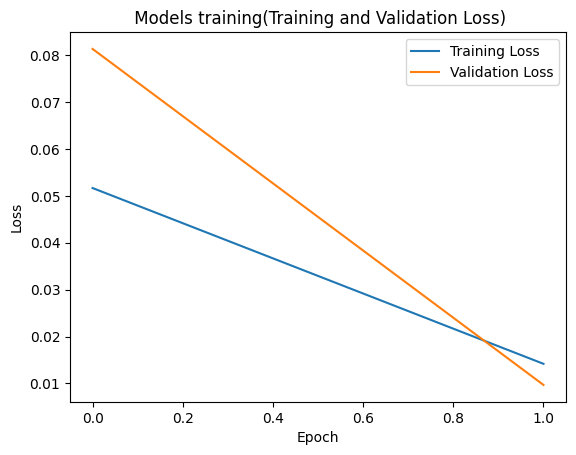

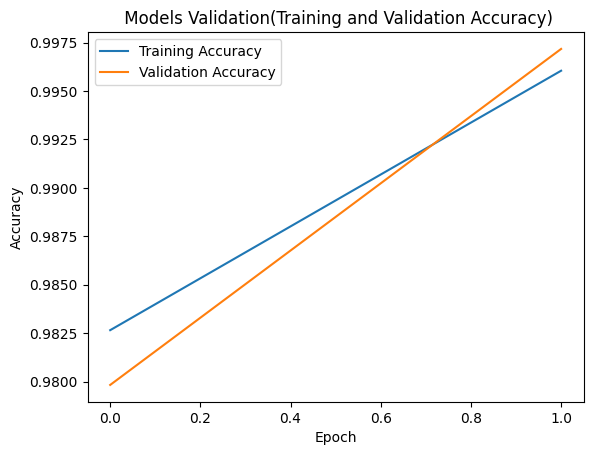

In [11]:
# compare the training loss and val traning from traning process
plt.plot(training_info.history['loss'], label='Training Loss')
plt.plot(training_info.history['val_loss'], label='Validation Loss')
plt.title(' Models training(Training and Validation Loss)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# compare the accuracy and val accuracy from traning process
plt.plot(training_info.history['accuracy'], label='Training Accuracy')
plt.plot(training_info.history['val_accuracy'], label='Validation Accuracy')
plt.title(' Models Validation(Training and Validation Accuracy)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Testing model with my own data, and chatGpt generated text

In [12]:

humen_test = '''
A windless Kiwi!
	In our journey, Do you still remember your goal, purpose,or your dream?  On the way to follow our dreams, we may forget our dreams when we may get tempted by the current interests, comfort zone, or pressures of life. These factors are like a layer of smog covering our path, therefore we forget our original tentation. There is an animated short film called “Kiwi!”It was created 16 years ago, made by Dony Permedi on 05/05/2006, In this short film, a flightless bird is trying to fly.  The author uses a very clever method to express dreams through the film. Also, this kiwi bird symbolizes people who are chasing their dreams.The author effetly portrays the appeal of pathos in his animated short film by the music transition, and action from the main character, in order to remind us what our dream is.
 Dony Permedi made this film to explore his thoughts about achieving dreams. The film uses joy and tragedy. These two contrasts complement the film and make the audience's understanding, and perception of this film stronger. Kiwi bird was born without wings, he spent his whole life just wanting to experience flying, congenital disabilities can't hinder his dreams. accompanied by light and entertaining music. Denny uses a metaphor, Kiwi bird as usself, metaphor on each big tree that is erected to the process of our dreams in fulfillment. From the cliff, he tied every tree vertically to the side of the cliff. We may be wondering why he is doing that, but once he jumps off the cliff, everything is making sense. Dony makes the audience think for themselves, thus connecting to the nature of the kiwi bird's disability. Also from the act of jumping off, kiwi knows that while he is “flying”, trees are the scenery. achieving his dream is hard. This little bird is very simple, all he wants is to enjoy the wind blowing to his feather. From the sense of this film, Kiwi bird is fighting everything to make his dream come true, even the cost is his life.  Also when Kiwi bird is “flying” off the cliff,  the musical atmosphere changes from anxious to joy, his wings pop out from nowwhere, but It’s small, and I believe the author is trying to leave a message that Kiwi Bird is keeping flapping his little wing to enjoy the wind. The author effectly shows the joy of Achieving a dream and fearlessness to the difficult to the audience through the kiwi bird. At the end of the film, we don't know kiwi bird will survive or not. He follows his dream fearlessly, making it worth learning from, and worth remaining to remain people what our dreams are.
Some of us may forget what we are fighting for. Are we fighting for a dream or are we fighting for our present interest? In this animated short film, Dony Permedi first shows us a character who is not a human but an animal. sad, and weak. After watching this video several times, I feel like we are a kiwi bird. When we were chasing our dream, we were so fragile, and faced many difficulty, and stress from real life. Also, in the sense of this film, A single tear, from a kiwi bird, is  the finishing touch, It connects between the achieving dream and accepting failue. If we want to acheving our dream, we shouldn't be affaid failure in our jouney.  From that tear, It represent our journey of life, we will feel the beauty of not only life, but death, the joy of achieving a dream, the rapture of happiness, the agony of despair, and everything in between are all included in one single tear to represent. Dony didn’t simplify the process of  first flying, he expressed Kiwi mixed feelings about his first fly by detailing kiwi bird’s action and the music transition. The author tries to use this short film to convince us about dreams and how powerfully a creature can execute to finish what he wants to. The purpose of his creation of this film is to let everyone who is fighting for their dreams continue to work hard and not give up. Kiwi is also fighting for his dream of flying, and we must also cheer for our future.
In conclusion, Kiwi birds is a value animated short for people to watch,  discover the meaning of hard work, and remain what our dream was, and knowing that the path of achieving a dream is hard. Dony Permedi convinced us to keep following our dream . Even though the situation is harder than we thought, we can still make a great step at a time, and acheive our dream one day.

'''

Ai_test = ''' 
Title: The Adventure of the Lost Necklace

One sunny morning, in the small town of Maplewood, young Sarah and her friends decided to explore the mysterious woods behind their school. Despite warnings from the elders about the woods being enchanted, the group, driven by curiosity and adventure, couldn’t resist the call of the unknown.

As they ventured deeper into the woods, the sunlight began to fade, filtered through the thick canopy above. They stumbled upon a small clearing where an ancient oak stood, its branches sprawling like the arms of a giant. Hanging from one of the branches, caught by a sliver of sunlight, was a beautiful, shimmering necklace.

Sarah, mesmerized by its beauty, decided to climb the tree. With careful steps and encouragement from her friends, she reached the branch and retrieved the necklace. The moment she touched it, a gentle breeze stirred, and a soft voice whispered through the leaves, "Return my necklace and free me."

Startled, Sarah almost lost her grip. Her friends, equally shocked, urged her to drop the necklace. But she felt an inexplicable connection to it and instead, wore it around her neck. The woods seemed to come alive, with the wind whispering and distant sounds of unknown creatures.

Determined to uncover the mystery, the group followed the voice, which seemed to guide them deeper into the forest. After what felt like hours, they arrived at a forgotten pond, its surface still and mirroring the sky. The voice became clearer, "Thank you for bringing me home."

As soon as Sarah stepped closer to the water, the surface rippled and an ethereal figure appeared. It was a forest spirit, trapped long ago by a wicked witch who envied her freedom. The necklace was the key to her bondage and, now, her release.

The spirit smiled at Sarah, "By returning the necklace, you have freed me. As a token of my gratitude, I shall grant you one wish." Overwhelmed but thoughtful, Sarah wished for the safety and prosperity of Maplewood and its inhabitants.

The spirit’s laughter echoed through the woods as she faded away, leaving behind a trail of sparkling lights. The necklace dissolved into the air, its purpose fulfilled. The children, changed forever by the encounter, returned home, their hearts full of joy and wonder.

That day, Sarah and her friends learned that courage and kindness could unlock the most magical mysteries. Maplewood thrived like never before, and the enchanted woods no longer seemed foreboding, but a place of wonder, guarding the secret of the brave little adventurers.'''

In [13]:

def predict_new_text(new_text):
    # new_text = remove_punctuation_and_stop_words(new_text)
    generated_rate = 0
    sequences = tokenizer.texts_to_sequences([new_text])
    padded_sequences = pad_sequences(sequences, padding='post', maxlen=max_len)
    
    tensor_text = tf.convert_to_tensor(padded_sequences , dtype=tf.int32)
 
    predictions = model.predict(tensor_text)
    
    if predictions[0][0] > 0.5:
        generated_rate = 1

    
    print("AI generated rate: ", generated_rate)
    print("AI generated rate: ", predictions[0][0])


predict_new_text(humen_test)
predict_new_text(Ai_test)





1/1 [==============================] - 1s 1s/step
AI generated rate:  0
AI generated rate:  0.00068018987
1/1 [==============================] - 0s 53ms/step
AI generated rate:  1
AI generated rate:  0.9999933


In [14]:
#save the tokenizer object

# import json
# tokenizer_json = tokenizer.to_json()
# with open('tokenizer.json', 'w', encoding='utf-8') as f:
#     f.write(json.dumps(tokenizer_json, ensure_ascii=False))

#Save the model
# model.save('classificationModel', save_format='tf')


###  Expermental setup

In [15]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [16]:
import sys
print(sys.version)

3.9.19 (main, Mar 21 2024, 17:21:27) [MSC v.1916 64 bit (AMD64)]


In [17]:
import tensorflow as tf
print("CUDA Version: ", tf.sysconfig.get_build_info()["cuda_version"])

CUDA Version:  64_112
